In [5]:
import matplotlib.pyplot as plt
import mdtraj as md
import torch
from loguru import logger
from tqdm import tqdm

from rocketshp import config

In [6]:
ATLAS_DATA_DIR = config.RAW_DATA_DIR / "atlas"
ATLAS_PROCESSED_DATA_DIR = config.PROCESSED_DATA_DIR / "atlas"

In [7]:
from rocketshp.data.atlas import ATLASDataModule

In [9]:
adl = ATLASDataModule(
    ATLAS_PROCESSED_DATA_DIR / "atlas_processed.h5",
    seq_features=True,
    struct_features=True,
    batch_size=5,
    num_workers=0,
    train_pct=0.8,
    val_pct=0.1,
    random_seed=0,
    struct_stage="ramachandran",
)
adl.setup("train")
ads = adl.dataset

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/s

In [6]:
batch = [adl.dataset[0], adl.dataset[1], adl.dataset[2], adl.dataset[3]]

In [7]:
x, l, y = _dict_collate_fn(batch)

NameError: name '_dict_collate_fn' is not defined

In [8]:
from rocketshp.dataset import _stack_variable_length_tensors


def _dict_collate_fn(batch):
    """
    Custom collate function for batching variable length sequences.

    Args:
        batch: List of tuples (features_dict, labels_dict) from the dataset

    Returns:
        features_dict: Dictionary of padded feature tensors
        labels_dict: Dictionary of label tensors
        lengths: Tensor of sequence lengths
    """
    # Separate features and labels
    features, labels = zip(*batch)

    # Get sequence lengths (assuming all features have same length)
    lengths = torch.tensor([next(iter(feat.values())).shape[0] for feat in features])

    # Initialize output dictionaries
    padded_features = {}
    padded_labels = {}

    # Pad and stack features
    for key in features[0].keys():
        sequences = [feat[key] for feat in features]
        padded_features[key] = _stack_variable_length_tensors(sequences)

    # Stack labels (assuming they don't need padding)
    for key in labels[0].keys():
        label_tensors = [label[key] for label in labels]
        padded_labels[key] = _stack_variable_length_tensors(label_tensors)

    return padded_features, lengths, padded_labels

ModuleNotFoundError: No module named 'rocketshp.dataset'

In [9]:
from rocketshp.modeling.architectures import FlexibilityModel

In [10]:
# fm = FlexibilityModel(1536, 1, 128, 8, 4)
# fm.train()

# loss_fn = torch.nn.MSELoss()

# losses = []
# optimizer = torch.optim.Adam(fm.parameters(), lr=1e-3)
# for epoch in range(1):
#     # logger.info(f"Epoch {epoch}")
#     for batch in tqdm(adl.train_dataloader(),leave=False):
#         (seq, struct), mask, y = batch
#         y_hat = fm((seq, struct))
#         loss = compute_masked_mse_loss(y_hat, y.unsqueeze(2), mask)
#         losses.append(loss.item())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [42]:
def load_checkpoint(chkpt):
    """
    FlexibilityModel(1536, 1, 128, 8, 4)
    """
    chk = torch.load(chkpt)
    hp = chk["hyper_parameters"]
    state_dict = {}
    fm = FlexibilityModel(
        hp["embedding_dim"],
        hp["output_dim"],
        hp["d_model"],
        hp["n_heads"],
        hp["n_layers"],
    )
    for k, v in chk["state_dict"].items():
        new_k = k.replace("child_model.", "")
        state_dict[new_k] = v
    fm.load_state_dict(state_dict)
    fm.eval()
    return fm

In [43]:
# fmnew = load_checkpoint("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_02/model-epoch=04-train_loss=0.05.pt.ckpt")
# fmnew = load_checkpoint("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/nepTest2/model-epoch=19-train_loss=0.01.pt.ckpt")
fmnew = load_checkpoint(
    "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_04/model-epoch=16-train_loss=0.01.pt.ckpt"
)

/tmp/ipykernel_3885106/3689996144.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(chkpt)


In [44]:
ckpt = torch.load(
    "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_04/model-epoch=16-train_loss=0.01.pt.ckpt"
)

/tmp/ipykernel_3885106/2199911354.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/rmsf_full_04/mo

In [ ]:
ckpt["hyper_parameters"]

{'num_parameters': 16793601,
 'batch_size': 8,
 'lr': 0.001,
 'max_epochs': 20,
 'num_data_workers': 31,
 'shuffle': True,
 'precision': 'highest',
 'embedding_dim': 1536,
 'output_dim': 1,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 4}

: 

In [9]:
from dataclasses import dataclass

import omegaconf


@dataclass
class PARAMETERS:
    batch_size: int = 64
    lr: float = 0.007
    max_epochs: int = 20
    num_data_workers: int = 31
    shuffle: bool = True
    precision: str = "highest"
    num_parameters: int = 0


p = PARAMETERS()
config = omegaconf.OmegaConf.create(p)
newp = omegaconf.OmegaConf.load("../configs/config.yml")
config.update(newp)

In [10]:
len(adl.dataset), len(adl.train_data), len(adl.val_data), len(adl.test_data)

(4167, 3333, 414, 420)

In [11]:
SAMPLE_I = 5


def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


f, rmsf = adl.train_data[SAMPLE_I]
key = adl.dataset.samples[adl.train_data.indices[SAMPLE_I]]
with torch.no_grad():
    yhat_both = fmnew([x.unsqueeze(0) for x in f]).squeeze()
    yhat_seqonly = fmnew(
        (f[0].unsqueeze(0), torch.zeros_like(f[1]).unsqueeze(0))
    ).squeeze()

bf_both = yhat_both.detach().cpu().numpy().squeeze()
bf_seqonly = yhat_seqonly.detach().cpu().numpy().squeeze()

plt.plot(rmsf, label="rmsf")
plt.plot(bf_both, label="predicted")
plt.plot(bf_seqonly, label="predicted seq only")
plt.legend()


from scipy.stats import pearsonr, spearmanr

spearman = spearmanr(rmsf, bf_both)
pearson = pearsonr(rmsf, bf_both)
mse = ((rmsf - bf_both) ** 2).mean()
logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

plt.show()

NameError: name 'fmnew' is not defined

In [13]:
pdb_code, rep = key.split("/")
traj = md.load_xtc(
    ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb",
)

In [14]:
from rocketshp.plot import display_trajectory

view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True)
view

NameError: name 'bf_both' is not defined

# RMSF Variance

In [4]:
import mdtraj as md

In [5]:
key = "5mdu_A/R2"
pdb_code, rep = key.split("/")
traj = md.load_xtc(
    ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb",
)

print(ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc")
print(ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb")

/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/5m/5mdu_A_prod_R2_fit.xtc
/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/5m/5mdu_A.pdb


In [6]:
traj

<mdtraj.Trajectory with 10001 frames, 2454 atoms, 157 residues, and unitcells at 0x7f1292e56cd0>

In [83]:
import numpy as np

subsample_rmsf = []
for _ in range(50):
    start = np.random.randint(0, traj.n_frames // 2)
    stride = np.random.randint(5, 50)
    t_sub = traj[start : start + traj.n_frames // 2 : stride]
    sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
    subsample_rmsf.append(sample)

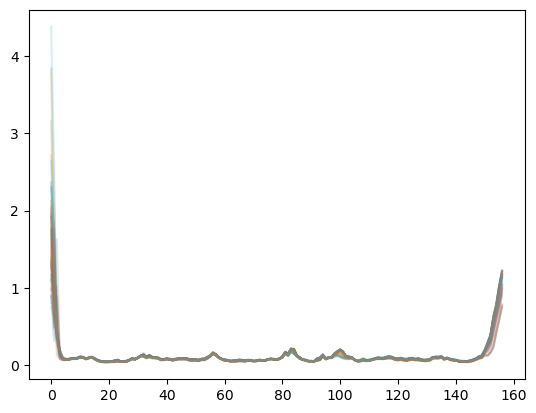

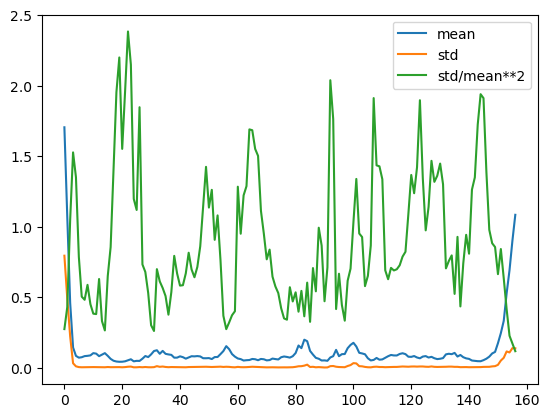

In [84]:
subsample_rmsf = np.stack(subsample_rmsf)
import matplotlib.pyplot as plt

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
plt.show()

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0), label="mean")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0), label="std")
plt.plot(
    np.arange(subsample_rmsf.shape[1]),
    subsample_rmsf.std(axis=0) / subsample_rmsf.mean(axis=0) ** 2,
    label="std/mean**2",
)
plt.legend()
plt.show()

# Autocorrelation

In [4]:
import mdtraj as md
import numpy as np

# load sample trajectory
key = "5mdu_A/R2"
pdb_code, rep = key.split("/")
traj = md.load_xtc(
    ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb",
)
# select ca only
traj = traj.atom_slice(traj.top.select("name CA"))

In [126]:
def position_autocorrelation(traj: md.Trajectory):
    pass


import numpy as np

In [127]:
from itertools import combinations


def compute_contacts(
    traj: md.Trajectory, scheme: str = "ca", ignore_nonprotein: bool = True
):
    return md.geometry.squareform(
        *md.compute_contacts(
            traj,
            contacts=list(combinations(np.arange(traj.n_residues), 2)),
            scheme=scheme,
            ignore_nonprotein=ignore_nonprotein,
        )
    )

In [128]:
def autocorrelate(X, tau):
    """
    X is (t, 1), where t is the number of time steps, and the remaining dimensions are a quantity that varies with time
    """
    x_shift_tau = X[tau:]
    x_numer = X[: len(x_shift_tau)] * x_shift_tau
    x_denom = X[: len(x_shift_tau)] * X[: len(x_shift_tau)]
    if (x_denom == 0).all():
        return 1
    c_tau = (x_numer / x_denom).mean()
    return c_tau

In [129]:
contacts = compute_contacts(traj)
res_0_1_dist = contacts[:, 0, 1]

In [130]:
tau = 10

x_shift_tau = res_0_1_dist[tau:]
x_numer = res_0_1_dist[: len(x_shift_tau)] * x_shift_tau
x_denom = res_0_1_dist[: len(x_shift_tau)] * res_0_1_dist[: len(x_shift_tau)]

In [139]:
from statsmodels.tsa.stattools import acf

In [140]:
from scipy import stats


def mean_abs_autocorr(autocorrs):
    return np.mean(np.abs(autocorrs))


c_autos = np.zeros((contacts.shape[1], contacts.shape[1]))
c_auto_means = np.zeros((contacts.shape[1], contacts.shape[1]))
# for c_other in tqdm(range(contacts.shape[1])):
for c_init, c_other in tqdm(combinations(range(contacts.shape[1]), 2)):
    # cts = []
    # for tau_max in range(contacts.shape[0]):
    #     c_tau = autocorrelate(contacts[:,1,c_other], tau_max)
    #     cts.append(c_tau)
    cts = acf(contacts[:, c_init, c_other], nlags=contacts.shape[0] - 1, fft=True)

    slope_0, intercept, r_value, p_value, std_err = stats.linregress(
        np.arange(cts.shape[0]), cts
    )
    c_autos[c_init, c_other] = slope_0
    c_autos[c_other, c_init] = slope_0
    c_auto_means[c_init, c_other] = mean_abs_autocorr(cts)
    c_auto_means[c_other, c_init] = mean_abs_autocorr(cts)

    # # Create figure and primary axis
    # fig, ax1 = plt.subplots()
    # line1 = ax1.plot(contacts[:,1,c_other], label="distance", color="lightgray")

    # ax2 = ax1.twinx()
    # ax2.plot(cts,label="autocorrelation")
    # # ax2.plot(-1.0 * , label="acf")
    # ax2.plot(np.arange(contacts.shape[0]) * slope_0 + intercept,label="linear fit")

    # plt.title(f"autocorrelation between res1 and res{c_other} (slope = {1e5*slope_0:.5f})")
    # plt.legend()
    # plt.show()

12246it [00:09, 1336.36it/s]


In [313]:
c_auto_means.min()

0.0

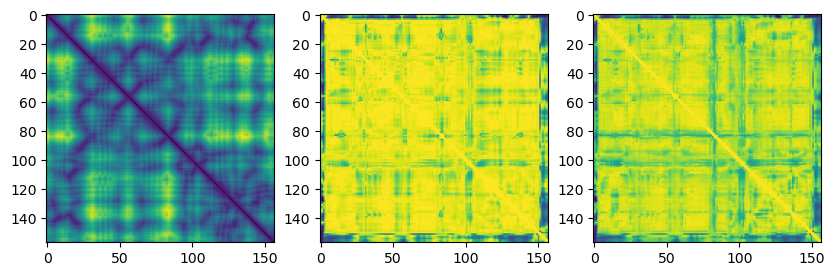

In [142]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(contacts[0])
ax[1].imshow(c_autos)
ax[2].imshow(-(c_auto_means))
plt.show()

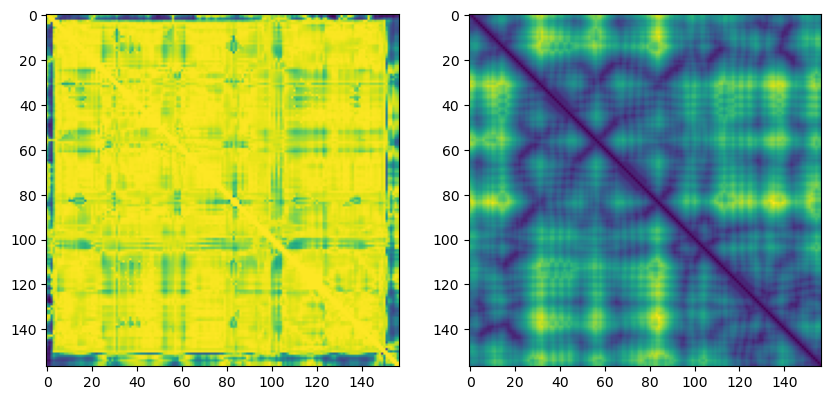

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(c_autos * 1e4)
ax[1].imshow(contacts[0])
plt.show()

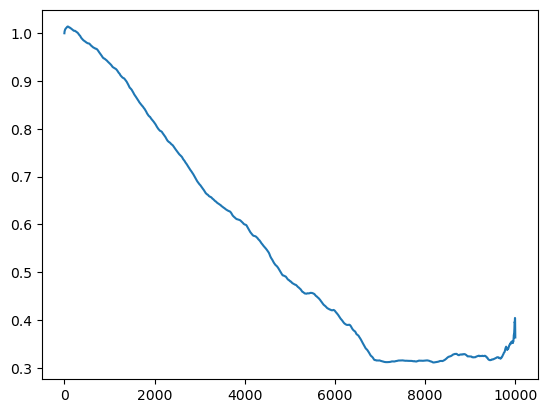

In [225]:
plt.plot(cts)

In [224]:
plt.plot(-1e4 * np.array(c_autos), label="autocorrelation")
plt.plot(contacts[0, 1, :], label="distance")
plt.legend()
plt.show()

SyntaxError: unmatched ')' (1161185746.py, line 1)

In [107]:
contacts.shape

(10001, 157, 157)

# Covariance Gaussian Network Model

In [35]:
from prody import GNM, parsePDB, showMode, showProtein

In [30]:
key = "5mdu_A/R2"
pdb_code, rep = key.split("/")
pdb_file = ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb"

In [31]:
prody_struct = parsePDB(str(pdb_file))

@> 2454 atoms and 1 coordinate set(s) were parsed in 0.12s.


In [32]:
calphas = prody_struct.select("calpha")

In [33]:
gnm = GNM(key)
gnm.buildKirchhoff(calphas, cutoff=7.0)
gnm.calcModes(n_modes=100)

@> Kirchhoff was built in 0.00s.
@> 100 modes were calculated in 0.01s.


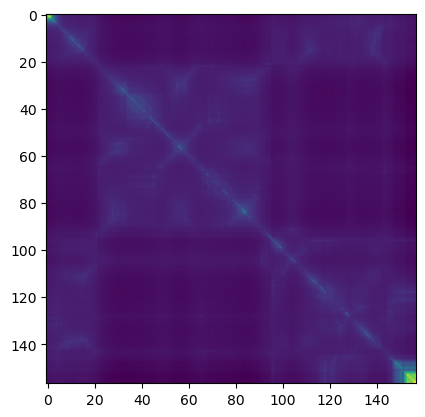

In [34]:
covar = gnm.getCovariance()
plt.imshow(covar)
plt.show()

([<matplotlib.lines.Line2D at 0x7ff3a7142b50>], [], [], [])

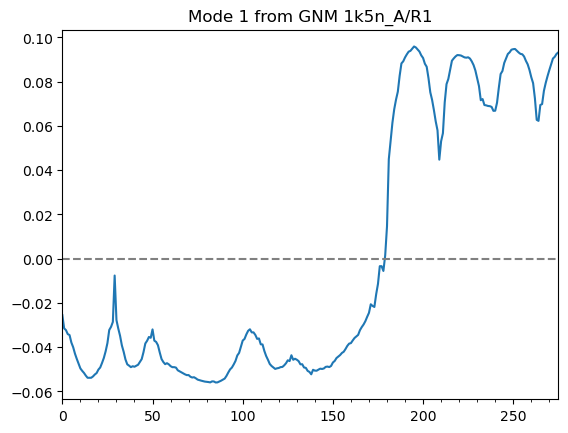

In [29]:
showMode(gnm[0])

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

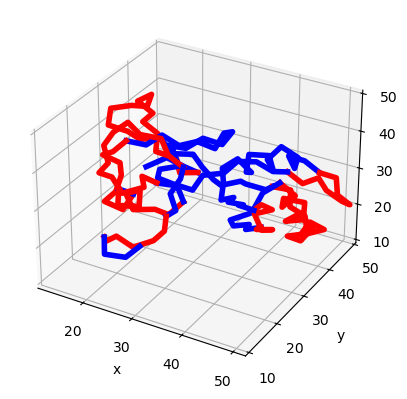

In [44]:
showProtein(calphas, mode=gnm[5])

# Cluster Trajectory RMSD

In [112]:
import mdtraj as md
import numpy as np

# load sample trajectory
# key = "5mdu_A/R2"
key = "1k5n_A/R3"
pdb_code, rep = key.split("/")
traj = md.load_xtc(
    ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",
    top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb",
)
# select ca only
traj = traj.atom_slice(traj.top.select("name CA"))

In [113]:
traj_rmsd = md.rmsd(traj, traj, 0)

In [114]:
rmsd_all = np.zeros((traj.n_frames, traj.n_frames))
for i in tqdm(range(traj.n_frames)):
    rmsd_all[i] = md.rmsd(traj, traj, i)

100%|██████████| 10001/10001 [00:06<00:00, 1602.29it/s]


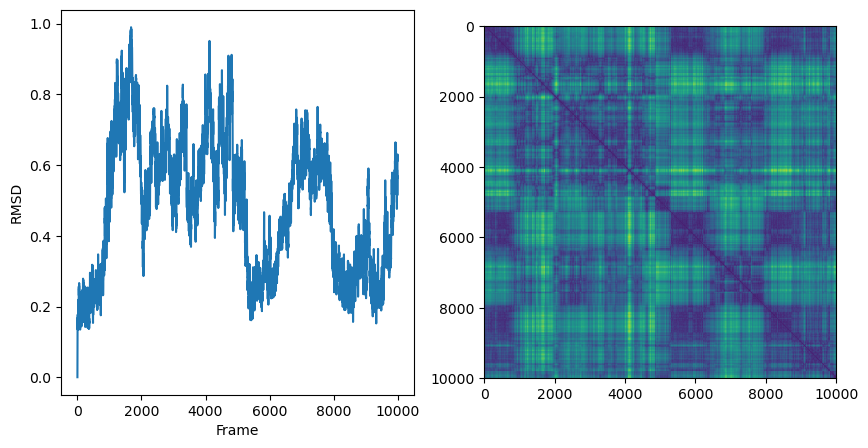

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rmsd_all[0, :])
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("RMSD")
ax[1].imshow(rmsd_all)
plt.show()

clustering with k=2

 sil score: 0.4429042526026621
clustering with k=3 sil score: 0.4202459394205641
clustering with k=4 sil score: 0.3803102923720195
clustering with k=5 sil score: 0.35014395355438177


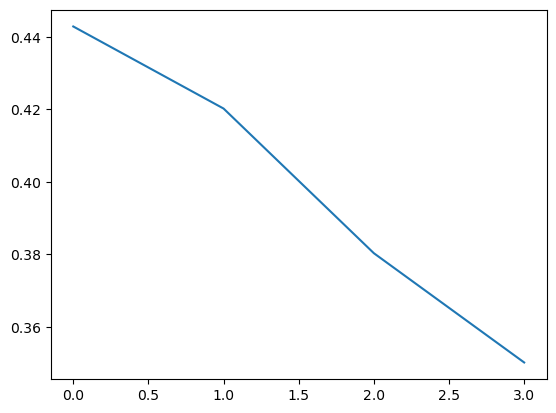

best k: 1


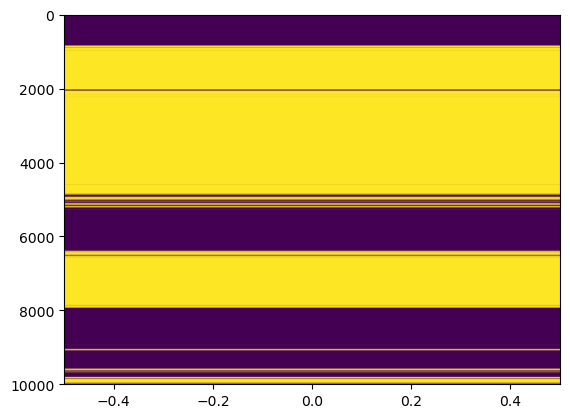

In [116]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# cluster frames with different values of k and evaluate silhouette_score, then select the best one and plot the clusters
sil_scores = []
kms = []
for k in range(2, 6):
    print(f"clustering with k={k}", end="")
    km = KMeans(n_clusters=k)
    km.fit(rmsd_all)
    kms.append(km)
    ss = silhouette_score(rmsd_all, km.labels_)
    print(f" sil score: {ss}")
    sil_scores.append(ss)
plt.plot(sil_scores)
plt.show()
km = kms[np.argmax(sil_scores)]
print(f"best k: {np.argmax(sil_scores) + 2}")
plt.imshow(km.labels_.reshape(-1, 1), aspect="auto")
plt.show()

In [86]:
rmsd_all.max()

0.5563317537307739

# MDSCAN

In [120]:
import mdtraj as md
import numpy as np

# load sample trajectory
# key = "5mdu_A/R3"
# key = "1k5n_A/R3"
# pdb_code, rep = key.split("/")
# traj = md.load_xtc(ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc", top=ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb")
# select ca only
# traj = traj.atom_slice(traj.top.select("name CA"))

In [121]:
from mdscan import clusterize as clt
from mdscan import qmst

In [122]:
K = 5
N_SPLITS = 3
MIN_CLUSTER_SIZE = 3000
CLUST_SEL_MET = "eom"

# # ++++ Exhausting neighborhoods +++++++++++++++++++++++++++++++++++++++++
print("\n[1/4] Exhausting neighborhoods...")
Kd_arr, dist_arr, nn_arr, exhausted, D1 = qmst.exhaust_neighborhoods(traj, K, N_SPLITS)


# ++++ Joining exhausted nodes ++++++++++++++++++++++++++++++++++++++++++++
dist_arr, nn_arr, exh_ord = qmst.join_exhausted(
    exhausted, Kd_arr, dist_arr, nn_arr, traj
)
print("\n[2/4] Construction of the quasi-Minimum Spanning Tree completed.")

# ++++ Checks +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# !!! to pass this check, you must set to -1 in nn_arr the argmin of dist_arr
# tree = qmst.check_tree(N1, nn_arr, dist_arr)
# cycl = nx.find_cycle(tree)
# connected = nx.is_connected(tree)
# network_exact = qmst.get_exact_MST(N1, traj, Kd_arr)
# mst_exact2 = qmst.get_prim_set(traj, Kd_arr)

# ======================================================================= #
# >>>> SECOND PART: CLUSTERS EXTRACTION                                   #
# ======================================================================= #
# ++++ Constructing the master topology of nodes ++++++++++++++++++++++++++
forest_top = clt.get_otree_topology2(nn_arr)

# ++++ Pruning the qMST +++++++++++++++++++++++++++++++++++++++++++++++++++
mcs = MIN_CLUSTER_SIZE
clusters, orig_clust_array = clt.prune_qMST2(nn_arr, dist_arr, forest_top, mcs)

# ++++ Assigning deltas and stabilities in a two-pass approach ++++++++++++
reclusters, ctree = clt.assign_deltas_and_stabilities2(clusters)
selected = [x for x in reclusters if reclusters[x]["delta"] == 1]

# ++++ Getting final clustering +++++++++++++++++++++++++++++++++++++++++++
final_array = clt.get_final_clusters(
    selected, reclusters, ctree, orig_clust_array, CLUST_SEL_MET, include_children=True
)


[1/4] Exhausting neighborhoods...


/mnt/home/ssledzieski/GitHub/MDScan/mdscan/vantage.py:92: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None
  p_dists = md.rmsd(subtraj, subtraj, real_p, precentered=True)[real_indices]
/mnt/home/ssledzieski/GitHub/MDScan/mdscan/vantage.py:174: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None
  vector = md.rmsd(self.traj, self.traj, point, precentered=True)
/mnt/home/ssledzieski/GitHub/MDScan/mdscan/qmst.py:219: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None
  idx_rmsd = md.rmsd(traj, traj, idx, precentered=True)



[2/4] Construction of the quasi-Minimum Spanning Tree completed.


/mnt/home/ssledzieski/GitHub/MDScan/mdscan/clusterize.py:128: RuntimeWarning: divide by zero encountered in divide
  lamb = 1 / dist_arr


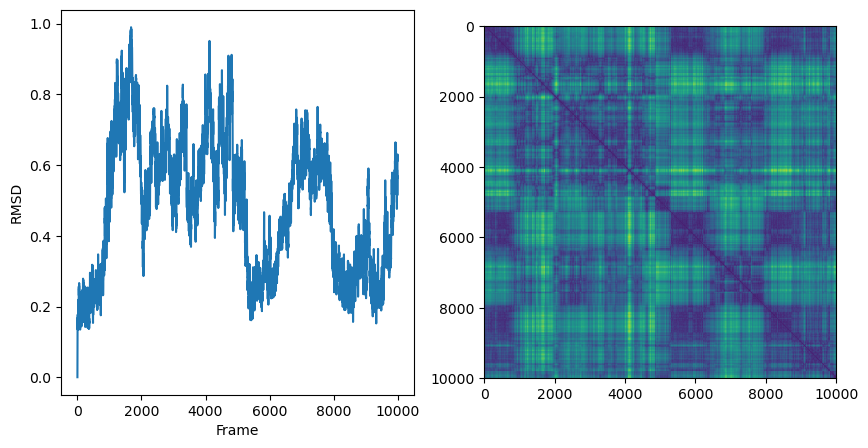

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rmsd_all[0, :])
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("RMSD")
ax[1].imshow(rmsd_all)
plt.show()

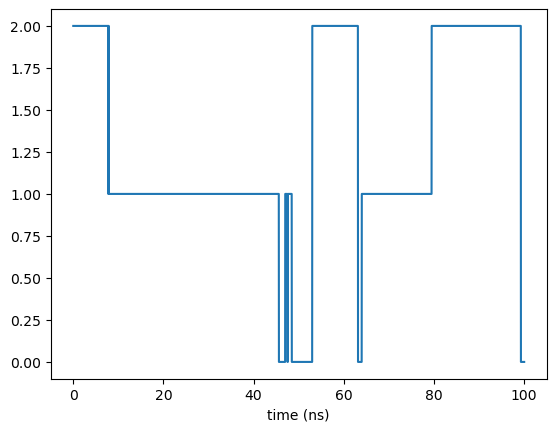

In [123]:
plt.plot(np.arange(0, 100.01, 0.01), orig_clust_array, label="o")
plt.xlabel("time (ns)")
plt.show()

# Dynamic Correlation

In [85]:
ca_traj = traj[::10]
atoms_to_keep = [a.index for a in ca_traj.topology.atoms if a.name == "CA"]
ca_traj.restrict_atoms(atoms_to_keep)

<mdtraj.Trajectory with 1001 frames, 157 atoms, 157 residues, and unitcells at 0x7fa18c36e790>

In [86]:
from rocketshp.plot import display_trajectory

In [79]:
num_nodes = ca_traj.xyz.shape[1]
num_frames = ca_traj.n_frames
LOCAL_DIST_CUTOFF = 0.75  # in nm


def residue_com(traj, res, frame=0):
    first_frame_coords = traj.xyz[frame, :, :]
    com = np.array([0.0, 0.0, 0.0])
    total_mass = 0.0
    for k, atom1 in enumerate(res.atoms):
        mass = atom1.element.mass
        com += mass * first_frame_coords[atom1.index, :]
        total_mass += mass

    com /= total_mass
    return com


# globally_aligned_nodes = graph.nodeCoordinates()
locally_aligned_nodes = np.zeros((num_nodes, 3 * num_frames)).astype(np.float32)
for i, res1 in enumerate(ca_traj.topology.residues):
    atom1_coords = residue_com(ca_traj, res1)
    close_atom_indices = []
    for j, res2 in enumerate(ca_traj.topology.residues):
        if i == j:
            continue
        atom2_coords = residue_com(ca_traj, res2)
        dist = np.linalg.norm(atom2_coords - atom1_coords)
        if dist <= LOCAL_DIST_CUTOFF:
            close_atom_indices.append(j)

    ca_traj.superpose(
        ca_traj, atom_indices=close_atom_indices, ref_atom_indices=close_atom_indices
    )
    # positions = ca_traj.xyz[:,i,:] - ca_traj.xyz[0,i,:]
    atom1_coords_aligned = residue_com(ca_traj, res1)
    positions = np.zeros((ca_traj.n_frames, 3))
    for L in range(ca_traj.n_frames):
        positions[L, :] = residue_com(ca_traj, res1, frame=L) - atom1_coords_aligned

    locally_aligned_nodes[i, 0:num_frames] = positions[:, 0]
    locally_aligned_nodes[i, num_frames : 2 * num_frames] = positions[:, 1]
    locally_aligned_nodes[i, 2 * num_frames : 3 * num_frames] = positions[:, 2]

    print(i)
    if i == 350:
        break

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [87]:
display_trajectory(ca_traj)

NGLWidget(max_frame=1000)

In [88]:
import torch

gcm = torch.load(
    "/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/5m/5mdu_A_2_local_step10_corr_matrix.pt"
)

/tmp/ipykernel_1361921/41828733.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcm = torch.load("/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/5m/5mdu_A_2_loc

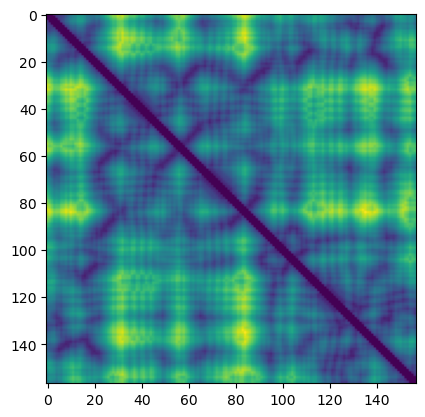

In [92]:
sqform = md.geometry.squareform(
    *md.compute_contacts(ca_traj[0], scheme="ca", ignore_nonprotein=True)
)
plt.imshow(sqform.squeeze())

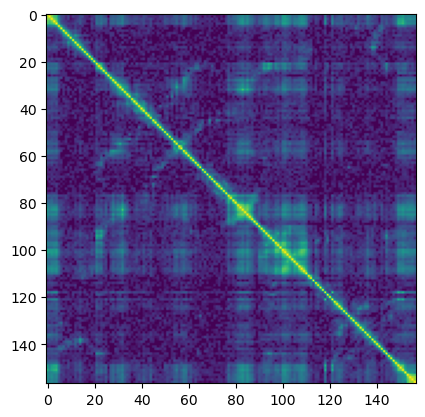

In [89]:
plt.imshow(gcm)

In [10]:
import numpy as np

# # 100 rows
# N = 100

# # 2 columns
# M = 2

# gaussian_2D = np.zeros((M, N)).astype(np.float32)
# for i in range(M):
#     gaussian_2D[i,:] = np.random.normal(size=N)

# with open("sample.dat", "w") as f:
#     f.write("column1\tcolumn2\n")
#     for i in range(N):
#         f.write(str(gaussian_2D[0,i])+"\t"+str(gaussian_2D[1,i])+"\n")

# import numpy as np

# 100 rows
N = 100

# 2 columns
M = 2

covariance_value = 0.9


def make_covariance_matrix(covariance_value):
    cov = np.array([[1.0, covariance_value], [covariance_value, 1.0]])
    return cov


gaussian_2D_mean = np.zeros(2)
gaussian_2D_cov = make_covariance_matrix(covariance_value)
gaussian_2D = np.random.multivariate_normal(
    mean=gaussian_2D_mean,
    cov=gaussian_2D_cov,
    size=N,
).T.astype(np.float32)

with open("sample.dat", "w") as f:
    f.write("column1\tcolumn2\n")
    for i in range(N):
        f.write(str(gaussian_2D[0, i]) + "\t" + str(gaussian_2D[1, i]) + "\n")

In [12]:
import cuarray
import netcalc
import numpy as np

# k-nearest neighbors number
k = 1

# Dimensionality of data
d = 1

# Two dimensions of distributions
xd = 2

# Number of data points in 2D distribution
N = 100

# Define all pair correlations that will be computed
num_nodes = 2
num_node_pairs = num_nodes**2
ab = cuarray.IntCuArray()
ab.init(num_node_pairs, 2)
for i in range(num_nodes):
    for j in range(num_nodes):
        node_pair_index = i * num_nodes + j
        ab[node_pair_index][0] = i
        ab[node_pair_index][1] = j

# Load the data into a numpy array
data_list = []
with open("sample.dat") as f:
    for i, line in enumerate(f.readlines()):
        if i == 0:
            # Skip the data header
            continue

        line = line.strip().split()
        col1_datum = line[0]
        col2_datum = line[1]
        data_list.append([col1_datum, col2_datum])

assert len(data_list) == N

two_columns_of_data = np.array(data_list, dtype=np.float32).T

# The input array
X = cuarray.FloatCuArray()
X.fromNumpy2D(two_columns_of_data)

# The output array
I = cuarray.FloatCuArray()

netcalc.mutualInformation(X, I, ab, k, N, xd, d, netcalc.GPU_PLATFORM)

mutual_information = I[0][1]

print("predicted mutual information for sample.dat:", mutual_information)

ImportError: libboost_filesystem.so.1.82.0: cannot open shared object file: No such file or directory

In [13]:
trajectory_file = "/mnt/home/ssledzieski/GitHub/netsci/protG_short.dcd"
topology_file = "/mnt/home/ssledzieski/GitHub/netsci/protG_short.pdb"
traj = md.load(trajectory_file, top=topology_file)
# trajectory_file = "sample.dcd"
# topology_file = str(ATLAS_DATA_DIR / f"{pdb_code[:2]}/{pdb_code}.pdb")

In [15]:
from rocketshp.plot import display_trajectory

view = display_trajectory(traj)
view

NGLWidget(max_frame=99)

In [16]:
import time

import cuarray
import netcalc
import netchem
import numpy as np

first_frame = 0
last_frame = 99
stride = 1

starttime = time.time()
print("Creating netchem graph")
graph = netchem.Graph()
graph.init(
    trajectoryFile=trajectory_file,
    topologyFile=topology_file,
    firstFrame=first_frame,
    lastFrame=last_frame,
    stride=stride,
)

# Output correlation matrix
R = cuarray.FloatCuArray()

# Correlation pairs to compute
ab = cuarray.IntCuArray()
num_nodes = graph.numNodes()
num_node_pairs = num_nodes**2

# Define all pair correlations that will be computed
ab.init(num_node_pairs, 2)
for i in range(num_nodes):
    for j in range(num_nodes):
        node_pair_index = i * num_nodes + j
        ab[node_pair_index][0] = i
        ab[node_pair_index][1] = j

# Number of data points
n = graph.numFrames()

# Dimensionality of the data
d = 3

xd = 2

# K-nearest-neighbors
k = 6

# CUDA platform
platform = 0

# Compute generalized correlation and output to proteinG_R
print(
    "Performing generalized correlation computation "
    f"on {n} data points with {num_nodes} nodes."
)
print(f"Time: {time.time() - starttime:.3f} s.")
netcalc.generalizedCorrelation(
    graph.nodeCoordinates(),
    R,
    ab,
    k,
    n,
    d,
    xd,
    platform,
)

# Gen. Corr. in numpy array object
R_np = R.toNumpy2D().reshape(num_nodes, num_nodes)
corr_matrix_filename = "proteinG_corr_matrix.txt"
print("Saving matrix to:", corr_matrix_filename)
np.savetxt(corr_matrix_filename, R_np)
print(f"Total time: {time.time() - starttime:.3f} s.")

ImportError: libboost_filesystem.so.1.82.0: cannot open shared object file: No such file or directory

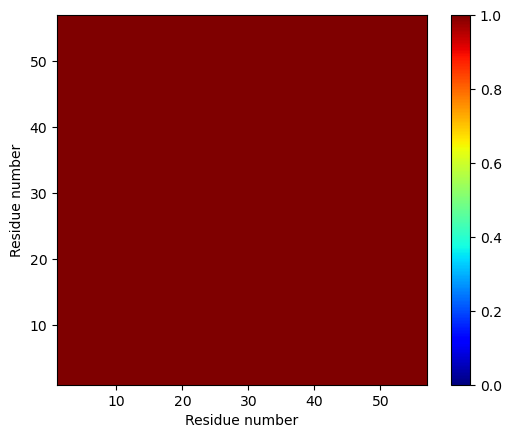

In [30]:
import matplotlib.pyplot as plt
import numpy as np

R_np = np.loadtxt("proteinG_corr_matrix.txt")

R_np = np.flip(R_np, axis=0)

R_figure_x = [i for i in range(num_nodes)]
R_figure_y = [i for i in range(num_nodes)]

im = plt.imshow(
    R_np,
    vmin=0.0,
    vmax=1.0,
    extent=[1, num_nodes + 1, 1, num_nodes + 1],
    cmap=plt.cm.jet,
)
im.set_interpolation("bilinear")
plt.xlabel("Residue number")
plt.ylabel("Residue number")
cbar = plt.colorbar(im)
plt.show()

In [16]:
num_frames = traj.n_frames
num_nodes = ca_traj.xyz.shape[1]
local_dist_cutoff = 0.75


def residue_com(traj, res, frame=0):
    first_frame_coords = traj.xyz[frame, :, :]
    com = np.array([0.0, 0.0, 0.0])
    total_mass = 0.0
    for k, atom1 in enumerate(res.atoms):
        mass = atom1.element.mass
        com += mass * first_frame_coords[atom1.index, :]
        total_mass += mass

    com /= total_mass
    return com


locally_aligned_nodes = np.zeros((num_nodes, 3 * num_frames)).astype(np.float32)

for i, res1 in enumerate(traj.topology.residues):
    atom1_coords = residue_com(traj, res1)
    close_atom_indices = []
    for j, res2 in enumerate(traj.topology.residues):
        if i == j:
            continue
        atom2_coords = residue_com(traj, res2)
        dist = np.linalg.norm(atom2_coords - atom1_coords)
        if dist <= local_dist_cutoff:
            close_atom_indices.append(j)

    traj.superpose(
        traj, atom_indices=close_atom_indices, ref_atom_indices=close_atom_indices
    )
    # positions = traj.xyz[:,i,:] - traj.xyz[0,i,:]
    atom1_coords_aligned = residue_com(traj, res1)
    positions = np.zeros((traj.n_frames, 3))
    for L in range(traj.n_frames):
        positions[L, :] = residue_com(traj, res1, frame=L) - atom1_coords_aligned

    locally_aligned_nodes[i, 0:num_frames] = positions[:, 0]
    locally_aligned_nodes[i, num_frames : 2 * num_frames] = positions[:, 1]
    locally_aligned_nodes[i, 2 * num_frames : 3 * num_frames] = positions[:, 2]

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION

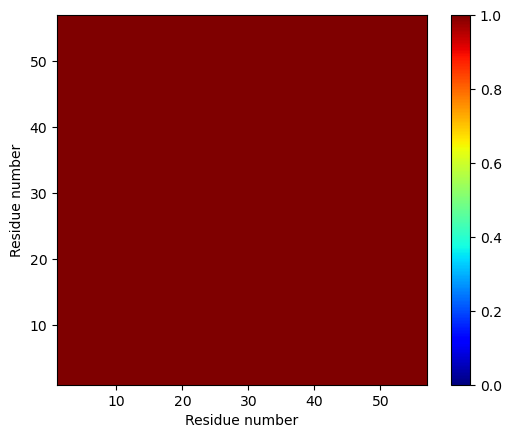

In [18]:
import matplotlib.pyplot as plt
import numpy as np

R_np = np.loadtxt("proteinG_corr_matrix.txt")

# Ranges of data
num_nodes = 56

R_np = np.flip(R_np, axis=0)

R_figure_x = [i for i in range(num_nodes)]
R_figure_y = [i for i in range(num_nodes)]

im = plt.imshow(
    R_np,
    vmin=0.0,
    vmax=1.0,
    extent=[1, num_nodes + 1, 1, num_nodes + 1],
    cmap=plt.cm.jet,
)
im.set_interpolation("bilinear")
plt.xlabel("Residue number")
plt.ylabel("Residue number")
cbar = plt.colorbar(im)
plt.show()